### Exercise

<div class="alert-success">

1. Transform the co2 and forest variables.
2. Discretize the result chosen.
3. Make the maps for the co2 and forest variables.
4. Add another variable (merge) from the web (or any other source). Transform it , discretize it, and map it.
   
    
</div>

# Copying what we'd already done

In [1]:
import os, geopandas as gpd

linkCountries = "https://github.com/in-Sinergy/mapasPractice/raw/main/World_Countries/World_Countries.shp"

countries=gpd.read_file(linkCountries)

In [2]:
#opening the other files
linkRivers = "https://github.com/in-Sinergy/mapasPractice/raw/main/World_Hydrography/World_Hydrography.shp"
linkCities = "https://github.com/in-Sinergy/mapasPractice/raw/main/World_Cities/World_Cities.shp"

cities=gpd.read_file(linkCities)
rivers=gpd.read_file(linkRivers)

<Axes: >

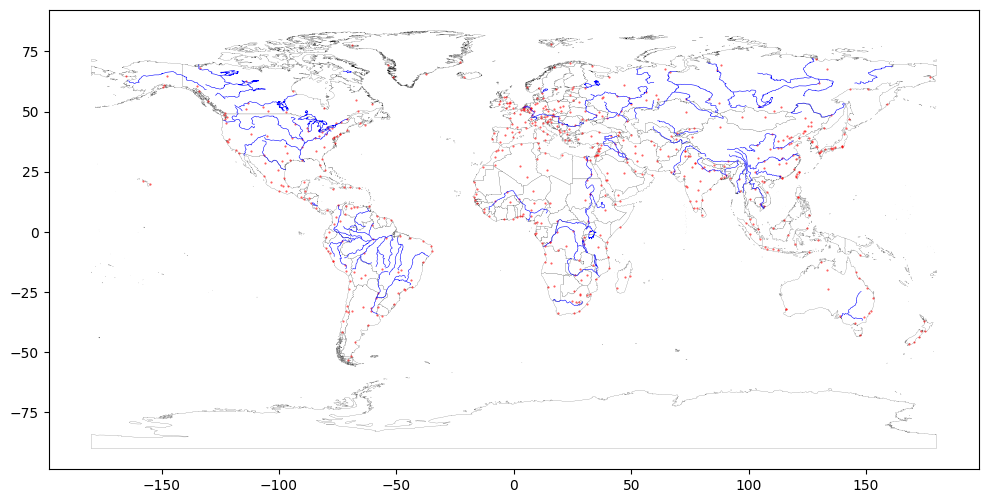

In [3]:
base = countries.plot(facecolor="white",
                      edgecolor='black',
                      linewidth=0.1,
                      figsize=(12,12))

rivers.plot(edgecolor='blue', linewidth=0.4,
            ax=base)
cities.plot(marker='.', color='red', markersize=1,alpha=0.7,
            ax=base)

In [4]:
countries.to_file(os.path.join("maps","worldMaps.gpkg"), layer='countries', driver="GPKG")
rivers.to_file(os.path.join("maps","worldMaps.gpkg"), layer='rivers', driver="GPKG")
cities.to_file(os.path.join("maps","worldMaps.gpkg"), layer='cities', driver="GPKG")

In [5]:
#adding cia data
import pandas as pd

fragilityCiaLink="https://github.com/CienciaDeDatosEspacial/merging/raw/main/FragilityCia_isos.csv"

fragilityCia=pd.read_csv(fragilityCiaLink)

In [6]:
countries['COUNTRY']=countries.COUNTRY.str.upper()

In [7]:
onlyFragilCia=set(fragilityCia.Country)- set(countries.COUNTRY)
onlyMap=set(countries.COUNTRY)- set(fragilityCia.Country)

In [8]:
!pip install thefuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.9 MB/s eta 0:00:00


In [9]:
from thefuzz import process

[(country, process.extractOne(country,onlyMap)) for country in sorted(onlyFragilCia)]
[(country, process.extractOne(country,onlyMap)) for country in sorted(onlyFragilCia)
 if process.extractOne(country,onlyMap)[1]>=90]
try1={country: process.extractOne(country,onlyMap)[0] for country in sorted(onlyFragilCia)
 if process.extractOne(country,onlyMap)[1]>=90}

In [10]:
fragilityCia.replace(to_replace={'Country':try1},inplace=True)

# updating
onlyFragilCia=set(fragilityCia.Country)- set(countries.COUNTRY)
onlyMap=set(countries.COUNTRY)- set(fragilityCia.Country)
# new matches
[(country, process.extractOne(country,onlyMap)) for country in sorted(onlyFragilCia)]
countries[countries.COUNTRY.str.contains('LAO|ESW|SWA')]
manualChanges={'SWAZILAND':'ESWATINI','LAOS':"LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)"}

countries.replace(to_replace={'COUNTRY':manualChanges},inplace=True)

# updating
onlyFragilCia=set(fragilityCia.Country)- set(countries.COUNTRY)
onlyMap=set(countries.COUNTRY)- set(fragilityCia.Country)
# new matches
[(country, process.extractOne(country,onlyMap)) for country in sorted(onlyFragilCia)]

# then:
try2={country: process.extractOne(country,onlyMap)[0] for country in sorted(onlyFragilCia)}

# changing
fragilityCia.replace(to_replace={'Country':try2},inplace=True)

# new update
onlyFragilCia=set(fragilityCia.Country)- set(countries.COUNTRY)
onlyMap=set(countries.COUNTRY)- set(fragilityCia.Country)

# new matches
[(country, process.extractOne(country,onlyMap)) for country in sorted(onlyFragilCia)]

[]

In [11]:
theMapAndData=countries.merge(fragilityCia,left_on='COUNTRY', right_on='Country')

theMapAndData.drop(columns=['Country'],inplace=True) # no need for this column

In [12]:
DataNames=['fragility', 'co2', 'ForestRev_gdp']
pd.melt(theMapAndData[DataNames])
import seaborn as sns
import matplotlib.pyplot as plt

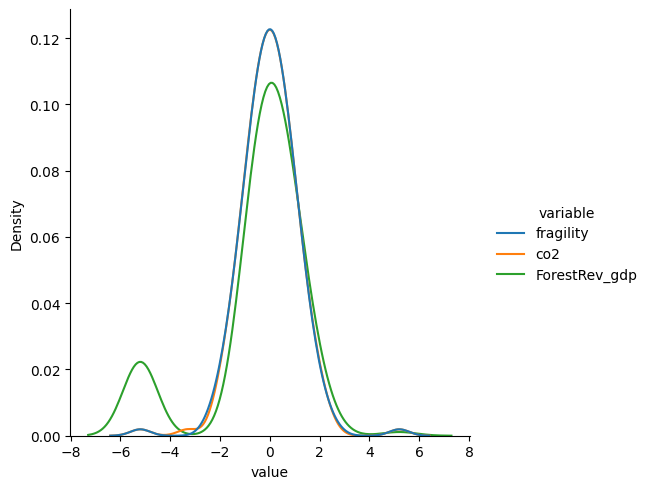

In [13]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(n_quantiles=99, random_state=0,output_distribution='normal') #or 'uniform'
QtScaled_data = scaler.fit_transform(theMapAndData[DataNames])

sns.displot(pd.melt(pd.DataFrame(QtScaled_data,columns=DataNames)),
            x="value", hue="variable",kind="kde",
            log_scale=(False,False))

In [14]:
theMapAndData['fragility_Qt']=QtScaled_data[:,0]

In [15]:
! pip install mapclassify

In [16]:
import mapclassify
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
theVar=theMapAndData.fragility_Qt
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

<Axes: ylabel='Classifier'>

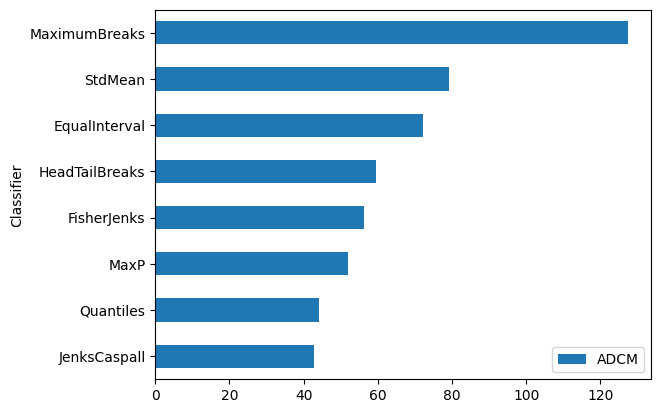

In [17]:
##comparing wit ACDM
class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
adcms.sort_values('ADCM').plot.barh(x='Classifier')

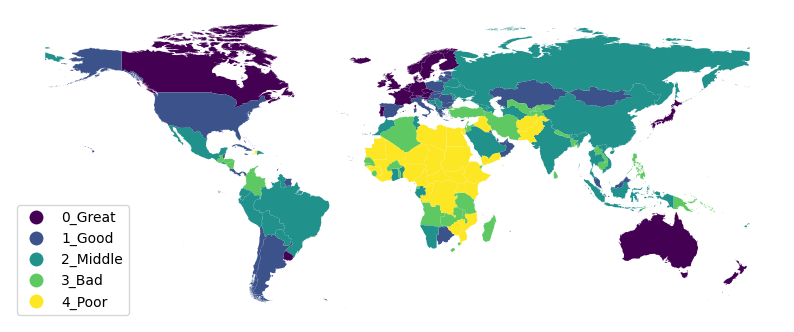

In [18]:
theMapAndData['fragility_Qt_jc5'] = jc5.yb
indexList=['fragility_Qt_jc5']
aggregator={'fragility_Qt': ['mean']}

pd.concat([theMapAndData[['fragility_Qt',col]].groupby(col,as_index=False).agg(aggregator) for col in indexList],axis=1)
# renaming
newLabelsForLevels={0:"0_Great", 1:"1_Good", 2:"2_Middle", 3:"3_Bad", 4:"4_Poor"}

theMapAndData['fragility_Qt_jc5_cat']=theMapAndData.loc[:,'fragility_Qt_jc5'].replace(newLabelsForLevels)
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10, 10))
theMapAndData.plot(column='fragility_Qt_jc5_cat', # variable to plot
                   cmap='viridis', # set of colors ##buscar en brewercolors
                   categorical=True, # can be interpreted as category
                   edgecolor='white', # border color
                   linewidth=0., # width of border
                   alpha=1, # level of transparency (0 is invisible)
                   legend=True, # need a legend?
                   # location of legend: 'best', 'upper right', 'upper left', 'lower left',
                   # 'lower right', 'right', 'center left', 'center right',
                   # 'lower center', 'upper center', 'center'
                   legend_kwds={'loc':"lower left"},
        ax=ax
       )

ax.set_axis_off()

In [19]:
theMapAndData.to_file(os.path.join("maps","worldMaps.gpkg"), layer='indicators', driver="GPKG")

# Getting to work

In [20]:
#transforming CO2 and Forest
theMapAndData['co2_Qt']=QtScaled_data[:,1]
theMapAndData['forest_Qt']=QtScaled_data[:,2]

**CO2**

In [21]:
np.random.seed(12345)
K=5
theVar=theMapAndData.co2_Qt
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

<Axes: ylabel='Classifier'>

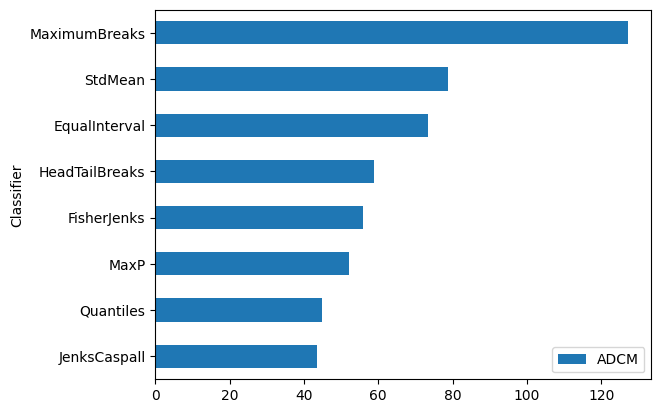

In [22]:
class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
adcms.sort_values('ADCM').plot.barh(x='Classifier')

In [23]:
theMapAndData['co2_Qt_jc5'] = jc5.yb

In [24]:
theMapAndData[['co2_Qt','co2_Qt_jc5']].head()

,co2_Qt,co2_Qt_jc5
0,-1.417436,0
1,-0.312096,1
2,0.903225,3
3,0.282063,2
4,-0.757475,1


In [25]:
indexList=['co2_Qt_jc5']
aggregator={'co2_Qt': ['mean']}

pd.concat([theMapAndData[['co2_Qt',col]].groupby(col,as_index=False).agg(aggregator) for col in indexList],axis=1)

,co2_Qt_jc5,co2_Qt
,,mean
0,0,-1.663108
1,1,-0.623926
2,2,0.014829
3,3,0.640064
4,4,1.630121


In [26]:
# renaming
newLabelsForLevels={0:"0_v_Low", 1:"1_Low", 2:"2_Medium", 3:"3_High", 4:"4_v_High"}

theMapAndData['co2_Qt_jc5_cat']=theMapAndData.loc[:,'co2_Qt_jc5'].replace(newLabelsForLevels)

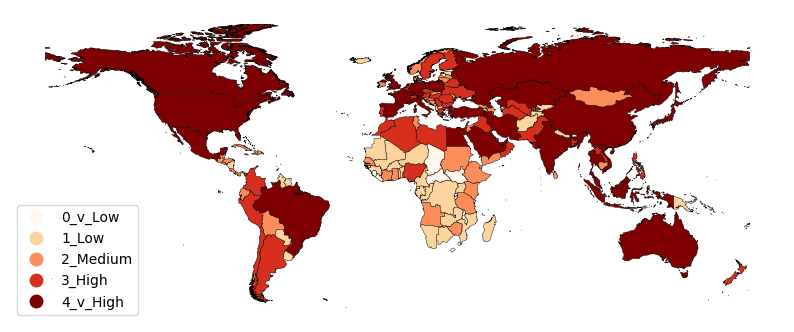

In [27]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10, 10))
theMapAndData.plot(column='co2_Qt_jc5_cat', # variable to plot
                   cmap='OrRd', # set of colors ##buscar en brewercolors
                   categorical=True, # can be interpreted as category
                   edgecolor='black', # border color
                   linewidth=0.3, # width of border
                   alpha=1, # level of transparency (0 is invisible)
                   legend=True, # need a legend?
                   # location of legend: 'best', 'upper right', 'upper left', 'lower left',
                   # 'lower right', 'right', 'center left', 'center right',
                   # 'lower center', 'upper center', 'center'
                   legend_kwds={'loc':"lower left"},
        ax=ax
       )

ax.set_axis_off()

In [28]:
theMapAndData.to_file(os.path.join("maps","worldMaps.gpkg"), layer='co2', driver="GPKG")

**FOREST**

In [29]:
np.random.seed(12345)
K=5
theVar=theMapAndData.forest_Qt
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

<Axes: ylabel='Classifier'>

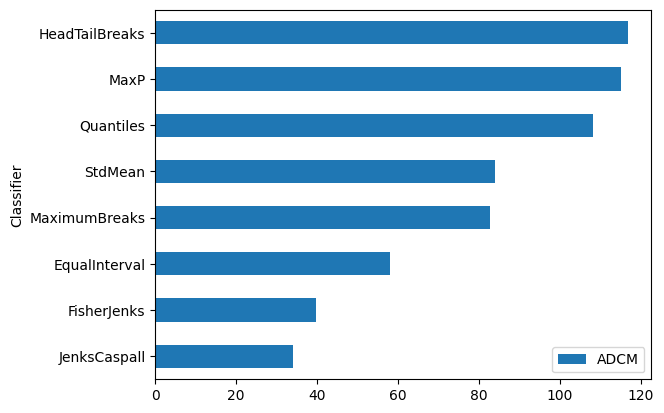

In [30]:
class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
adcms.sort_values('ADCM').plot.barh(x='Classifier')

In [31]:
theMapAndData['forest_Qt_jc5'] = jc5.yb
theMapAndData[['forest_Qt','forest_Qt_jc5']].head()

,forest_Qt,forest_Qt_jc5
0,-5.199338,0
1,-0.076809,2
2,-0.352465,2
3,-0.827130,1
4,-0.106447,2


In [32]:
indexList=['forest_Qt_jc5']
aggregator={'forest_Qt': ['mean']}

pd.concat([theMapAndData[['forest_Qt',col]].groupby(col,as_index=False).agg(aggregator) for col in indexList],axis=1)

,forest_Qt_jc5,forest_Qt
,,mean
0,0,-5.199338
1,1,-0.762467
2,2,-0.050787
3,3,0.635412
4,4,1.657795


In [33]:
# renaming
newLabelsForLevels={0:"0_v_Low", 1:"1_Low", 2:"2_Medium", 3:"3_High", 4:"4_v_High"}

theMapAndData['forest_Qt_jc5_cat']=theMapAndData.loc[:,'forest_Qt_jc5'].replace(newLabelsForLevels)

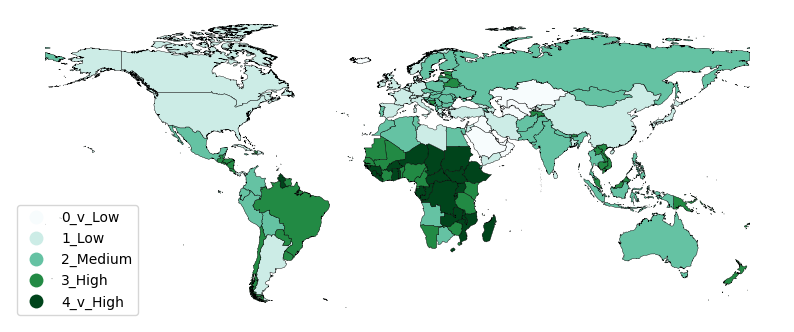

In [34]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10, 10))
theMapAndData.plot(column='forest_Qt_jc5_cat', # variable to plot
                   cmap='BuGn', # set of colors ##buscar en brewercolors
                   categorical=True, # can be interpreted as category
                   edgecolor='black', # border color
                   linewidth=0.3, # width of border
                   alpha=1, # level of transparency (0 is invisible)
                   legend=True, # need a legend?
                   # location of legend: 'best', 'upper right', 'upper left', 'lower left',
                   # 'lower right', 'right', 'center left', 'center right',
                   # 'lower center', 'upper center', 'center'
                   legend_kwds={'loc':"lower left"},
        ax=ax
       )

ax.set_axis_off()

In [35]:
theMapAndData.to_file(os.path.join("maps","worldMaps.gpkg"), layer='forest', driver="GPKG")

# New variable

In [36]:
linkPBI = "https://github.com/in-Sinergy/mapasPractice/raw/main/Real%20GDP%20per%20capita.csv"
PBI=pd.read_csv(linkPBI)

In [37]:
PBI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 224 non-null    object
 1   slug                 224 non-null    object
 2   value                224 non-null    object
 3   date_of_information  224 non-null    int64 
 4   ranking              224 non-null    int64 
 5   region               224 non-null    object
dtypes: int64(2), object(4)
memory usage: 10.6+ KB


**CLEANING THE DATA**

In [38]:
#colocando los países en mayúscula
PBI['Country']= PBI.name.str.upper()

In [39]:
PBI.drop(columns='name', inplace=True)
PBI

,slug,value,date_of_information,ranking,region,Country
0,liechtenstein,"$139,100",2009,1,Europe,LIECHTENSTEIN
1,luxembourg,"$117,700",2022,2,Europe,LUXEMBOURG
2,monaco,"$115,700",2015,3,Europe,MONACO
3,ireland,"$112,400",2022,4,Europe,IRELAND
4,singapore,"$108,000",2022,5,East and Southeast Asia,SINGAPORE
...,...,...,...,...,...,...
219,mozambique,"$1,300",2022,220,Africa,MOZAMBIQUE
220,niger,"$1,300",2022,221,Africa,NIGER
221,congo-democratic-republic-of-the,"$1,100",2022,222,Africa,"CONGO, DEMOCRATIC REPUBLIC OF THE"
222,central-african-republic,$800,2022,223,Africa,CENTRAL AFRICAN REPUBLIC


In [40]:
#arreglando la columna de value para que sea solo el valor numérico
PBI['value']=PBI.value.str.replace(pat=',',repl='', regex=True)

In [41]:
PBI['value']=PBI.value.str.extract(pat=r'(\d+)',expand=True)

In [42]:
PBI['value']=pd.to_numeric(PBI.value)

In [43]:
#una vez listo, se hace el merge con el database principal
onlyPBI=set(PBI.Country)- set(countries.COUNTRY)
onlyMap=set(countries.COUNTRY)- set(PBI.Country)

In [44]:
[(country, process.extractOne(country,onlyMap)) for country in sorted(onlyPBI)
  if process.extractOne(country,onlyMap)[1]>=90]

[('AMERICAN SAMOA', ('AMERICAN SAMOA (US)', 95)),
 ('ARUBA', ('ARUBA (NETHERLANDS)', 90)),
 ('BAHAMAS, THE', ('BAHAMAS', 90)),
 ('BERMUDA', ('BERMUDA (UK)', 90)),
 ('BRITISH VIRGIN ISLANDS', ('BRITISH VIRGIN ISLANDS(UK)', 95)),
 ('CAYMAN ISLANDS', ('CAYMAN ISLANDS (UK)', 95)),
 ('CONGO, DEMOCRATIC REPUBLIC OF THE',
  ('DEMOCRATIC REPUBLIC OF THE CONGO', 95)),
 ('CONGO, REPUBLIC OF THE', ('DEMOCRATIC REPUBLIC OF THE CONGO', 95)),
 ('COOK ISLANDS', ('COOK ISLANDS (NEW ZEALAND)', 90)),
 ('CURACAO', ('CURACAO (NETHERLANDS)', 90)),
 ('FAROE ISLANDS', ('FAROE ISLANDS (DENMARK)', 90)),
 ('FRENCH POLYNESIA', ('FRENCH POLYNESIA (FRANCE)', 90)),
 ('GAMBIA, THE', ('GAMBIA', 90)),
 ('GIBRALTAR', ('GIBRALTAR (UK)', 95)),
 ('GREENLAND', ('GREENLAND (DENMARK)', 90)),
 ('GUAM', ('GUAM (US)', 90)),
 ('GUERNSEY', ('GUERNSEY (UK)', 90)),
 ('ISLE OF MAN', ('ISLE OF MAN (UK)', 95)),
 ('JERSEY', ('JERSEY (UK)', 90)),
 ('KOREA, NORTH', ('NORTH KOREA', 95)),
 ('KOREA, SOUTH', ('SOUTH KOREA', 95)),
 ('MICRONES

In [45]:
try1={country: process.extractOne(country,onlyMap)[0] for country in sorted(onlyPBI)
 if process.extractOne(country,onlyMap)[1]>=90}
try1

{'AMERICAN SAMOA': 'AMERICAN SAMOA (US)',
 'ARUBA': 'ARUBA (NETHERLANDS)',
 'BAHAMAS, THE': 'BAHAMAS',
 'BERMUDA': 'BERMUDA (UK)',
 'BRITISH VIRGIN ISLANDS': 'BRITISH VIRGIN ISLANDS(UK)',
 'CAYMAN ISLANDS': 'CAYMAN ISLANDS (UK)',
 'CONGO, DEMOCRATIC REPUBLIC OF THE': 'DEMOCRATIC REPUBLIC OF THE CONGO',
 'CONGO, REPUBLIC OF THE': 'DEMOCRATIC REPUBLIC OF THE CONGO',
 'COOK ISLANDS': 'COOK ISLANDS (NEW ZEALAND)',
 'CURACAO': 'CURACAO (NETHERLANDS)',
 'FAROE ISLANDS': 'FAROE ISLANDS (DENMARK)',
 'FRENCH POLYNESIA': 'FRENCH POLYNESIA (FRANCE)',
 'GAMBIA, THE': 'GAMBIA',
 'GIBRALTAR': 'GIBRALTAR (UK)',
 'GREENLAND': 'GREENLAND (DENMARK)',
 'GUAM': 'GUAM (US)',
 'GUERNSEY': 'GUERNSEY (UK)',
 'ISLE OF MAN': 'ISLE OF MAN (UK)',
 'JERSEY': 'JERSEY (UK)',
 'KOREA, NORTH': 'NORTH KOREA',
 'KOREA, SOUTH': 'SOUTH KOREA',
 'MICRONESIA, FEDERATED STATES OF': 'FEDERATED STATES OF MICRONESIA',
 'MONTSERRAT': 'MONTSERRAT (UK)',
 'NEW CALEDONIA': 'NEW CALEDONIA (FRANCE)',
 'NIUE': 'NIUE (NEW ZEALAND)',
 '

In [46]:
PBI.replace(to_replace={'Country':try1},inplace=True)

# updating
onlyPBI=set(PBI.Country)- set(countries.COUNTRY)
onlyMap=set(countries.COUNTRY)- set(PBI.Country)
# new matches
[(country, process.extractOne(country,onlyMap)) for country in sorted(onlyPBI)]

[('BURMA', ('COCOS (KEELING) ISLANDS (AUSTRALIA)', 54)),
 ('CABO VERDE', ('CAPE VERDE', 80)),
 ("COTE D'IVOIRE", ('IVORY COAST', 63)),
 ('CZECHIA', ('CZECH REPUBLIC', 75)),
 ('FALKLAND ISLANDS (ISLAS MALVINAS)', ('FALKLAND ISLANDS (UK)', 86)),
 ('GAZA STRIP', ('COCOS (KEELING) ISLANDS (AUSTRALIA)', 48)),
 ('HONG KONG', ('CONGO', 68)),
 ('KOSOVO', ('JOHNSTON ATOLL (US)', 45)),
 ('LAOS', ("LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)", 51)),
 ('MACAU', ("LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)", 54)),
 ('SAINT LUCIA', ('ST. LUCIA', 80)),
 ('SINT MAARTEN', ('MYANMAR', 62)),
 ('TIMOR-LESTE', ('EAST TIMOR', 81)),
 ('WEST BANK', ('WESTERN SAHARA', 57))]

In [47]:
#cambios manuales
countries[countries.COUNTRY.str.contains('MYA|LAO|FALK|PAL')]
manualChanges={'MYANMAR':'BURMA','LAOS':"LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)", 'FALKLAND ISLANDS (UK)':'FALKLAND ISLANDS (ISLAS MALVINAS)',
               'GAZA': 'GAZA STRIP'}

In [48]:
countries.replace(to_replace={'COUNTRY':manualChanges},inplace=True)
onlyPBI=set(PBI.Country)- set(countries.COUNTRY)
onlyMap=set(countries.COUNTRY)- set(PBI.Country)
# new matches
[(country, process.extractOne(country,onlyMap)) for country in sorted(onlyPBI)]

[('CABO VERDE', ('CAPE VERDE', 80)),
 ("COTE D'IVOIRE", ('IVORY COAST', 63)),
 ('CZECHIA', ('CZECH REPUBLIC', 75)),
 ('GAZA STRIP', ('COCOS (KEELING) ISLANDS (AUSTRALIA)', 48)),
 ('HONG KONG', ('CONGO', 68)),
 ('KOSOVO', ('JOHNSTON ATOLL (US)', 45)),
 ('LAOS', ("LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)", 51)),
 ('MACAU', ("LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)", 54)),
 ('SAINT LUCIA', ('ST. LUCIA', 80)),
 ('SINT MAARTEN', ('ST. PIERRE AND MIQUELON (FRANCE)', 50)),
 ('TIMOR-LESTE', ('EAST TIMOR', 81)),
 ('WEST BANK', ('WESTERN SAHARA', 57))]

In [49]:
try2={country: process.extractOne(country,onlyMap)[0] for country in sorted(onlyPBI)}
try2

{'CABO VERDE': 'CAPE VERDE',
 "COTE D'IVOIRE": 'IVORY COAST',
 'CZECHIA': 'CZECH REPUBLIC',
 'GAZA STRIP': 'COCOS (KEELING) ISLANDS (AUSTRALIA)',
 'HONG KONG': 'CONGO',
 'KOSOVO': 'JOHNSTON ATOLL (US)',
 'LAOS': "LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)",
 'MACAU': "LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)",
 'SAINT LUCIA': 'ST. LUCIA',
 'SINT MAARTEN': 'ST. PIERRE AND MIQUELON (FRANCE)',
 'TIMOR-LESTE': 'EAST TIMOR',
 'WEST BANK': 'WESTERN SAHARA'}

In [50]:
# changing
PBI.replace(to_replace={'Country':try2},inplace=True)

**MERGING**

In [51]:
theMapAndData=countries.merge(PBI,left_on='COUNTRY', right_on='Country')

theMapAndData.drop(columns=['Country'],inplace=True) # no need for this column
# here it is (new map):
theMapAndData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   COUNTRY              224 non-null    object  
 1   geometry             224 non-null    geometry
 2   slug                 224 non-null    object  
 3   value                224 non-null    int64   
 4   date_of_information  224 non-null    int64   
 5   ranking              224 non-null    int64   
 6   region               224 non-null    object  
dtypes: geometry(1), int64(3), object(3)
memory usage: 12.4+ KB


In [59]:
theMapAndData.rename(columns = {'value':'PBI_val'}, inplace = True)

In [61]:
DataNames=['PBI_val']
pd.melt(theMapAndData[DataNames])

,variable,value
0,PBI_val,41300
1,PBI_val,22300
2,PBI_val,1500
3,PBI_val,11200
4,PBI_val,15100
...,...,...
219,PBI_val,2200
220,PBI_val,1600
221,PBI_val,12400
222,PBI_val,3900


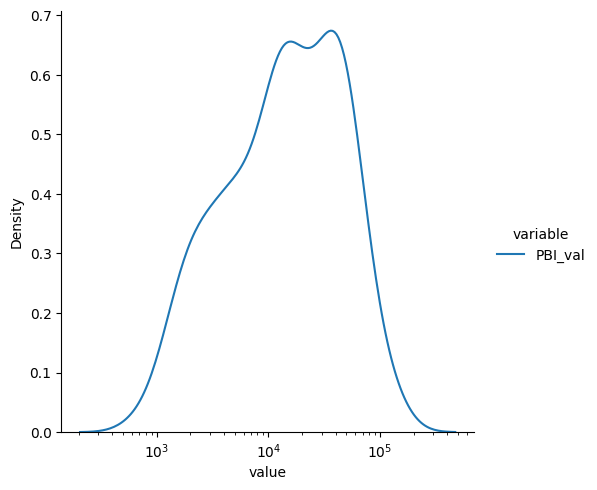

In [62]:
sns.displot(pd.melt(theMapAndData[DataNames]),
            x="value", hue="variable",kind="kde",
            log_scale=(True,False))

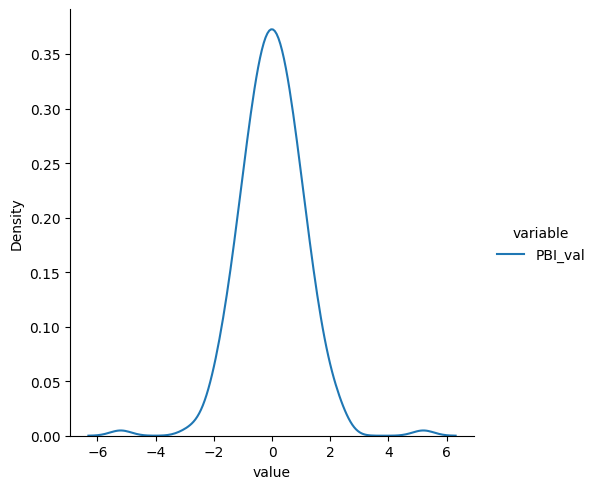

In [63]:
from sklearn.preprocessing import QuantileTransformer ##para datos con dms atípicos. Los transforma para que no influyan
scaler = QuantileTransformer(n_quantiles=99, random_state=0,output_distribution='normal') #or 'uniform'
QtScaled_data = scaler.fit_transform(theMapAndData[DataNames])

sns.displot(pd.melt(pd.DataFrame(QtScaled_data,columns=DataNames)),
            x="value", hue="variable",kind="kde",
            log_scale=(False,False))

In [64]:
theMapAndData['PBI_Qt']=QtScaled_data[:,0]

In [65]:
np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
theVar=theMapAndData.PBI_Qt
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

<Axes: ylabel='Classifier'>

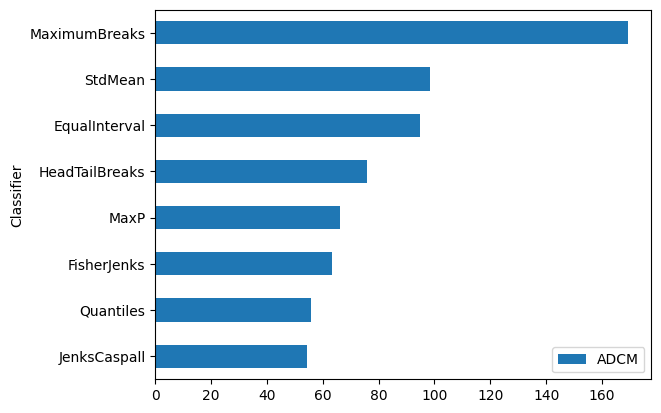

In [66]:
class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
adcms.sort_values('ADCM').plot.barh(x='Classifier')

In [67]:
theMapAndData['PBI_Qt_jc5'] = jc5.yb

In [68]:
indexList=['PBI_Qt_jc5']
aggregator={'PBI_Qt': ['mean']}

pd.concat([theMapAndData[['PBI_Qt',col]].groupby(col,as_index=False).agg(aggregator) for col in indexList],axis=1)

,PBI_Qt_jc5,PBI_Qt
,,mean
0,0,-1.537548
1,1,-0.577404
2,2,0.027795
3,3,0.656451
4,4,1.630204


In [69]:
# renaming
newLabelsForLevels={0:"0_VBad", 1:"1_Bad", 2:"2_Regular", 3:"3_Good", 4:"4_Great"}

theMapAndData['PBI_Qt_jc5_cat']=theMapAndData.loc[:,'PBI_Qt_jc5'].replace(newLabelsForLevels) #categorica

# we have
theMapAndData[['PBI_Qt','PBI_Qt_jc5','PBI_Qt_jc5_cat']].head()

,PBI_Qt,PBI_Qt_jc5,PBI_Qt_jc5_cat
0,0.801583,3,3_Good
1,0.289846,2,2_Regular
2,-1.741291,0,0_VBad
3,-0.258633,2,2_Regular
4,0.025581,2,2_Regular


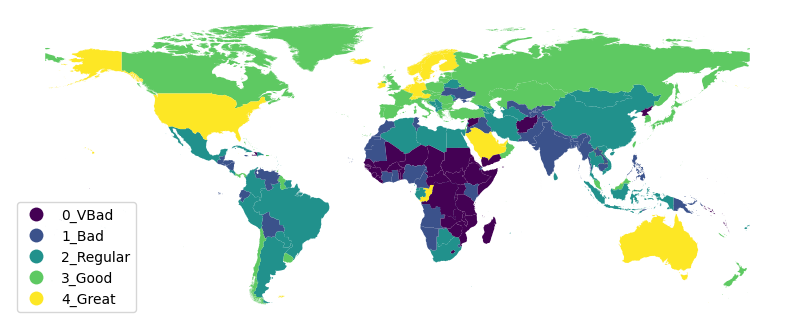

In [70]:
f, ax = plt.subplots(1, figsize=(10, 10))
theMapAndData.plot(column='PBI_Qt_jc5_cat', # variable to plot
                   cmap='viridis', # set of colors ##buscar en brewercolors
                   categorical=True, # can be interpreted as category
                   edgecolor='white', # border color
                   linewidth=0., # width of border
                   alpha=1, # level of transparency (0 is invisible)
                   legend=True, # need a legend?
                   # location of legend: 'best', 'upper right', 'upper left', 'lower left',
                   # 'lower right', 'right', 'center left', 'center right',
                   # 'lower center', 'upper center', 'center'
                   legend_kwds={'loc':"lower left"},
        ax=ax
       )

ax.set_axis_off()

In [71]:
theMapAndData.to_file(os.path.join("maps","worldMaps.gpkg"), layer='PBI', driver="GPKG")